# Explorative Datenanalyse nach OpenIntro-Prinzipien

Dieses Notebook folgt den Kernideen aus *OpenIntro - Introduction to Modern Statistics*: Beschreibung der Datenstruktur, univariate Exploration, Untersuchung bivariater Beziehungen sowie Identifikation von Ausreissern und gruppenspezifischen Mustern. Alle Schritte sollen die spaetere Modellierung des `profile_fdi_rating` fundieren.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("seaborn-v0_8")
sns.set_theme(context="notebook", style="whitegrid", palette="deep")

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
DATA_PATH = PROJECT_ROOT / "data/processed/player_stats_all.csv"
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
df["log_total_earnings"] = np.log1p(df["profile_total_earnings"].clip(lower=0).fillna(0))
df["country"] = df["country_code"].fillna("UNK")
print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
df.head()

Rows: 2,978 | Columns: 34


,player_id,player_name,country_code,birth_date,age,profile_total_earnings,profile_9_darters,profile_season_win_pct,profile_tour_card_years,profile_fdi_rating,...,last_12_months_171_180_s,last_12_months_140_s,last_12_months_131_140_s,last_12_months_functional_doubles_pcnt,api_rank,api_overall_stat,api_sum_field1,api_sum_field2,log_total_earnings,country
0,5403,Luke Littler,ENG,21/01/2007,18.0,2141879.0,8.0,80.0,1.0,1972.0,...,998.0,1268.0,1960.0,49.31,1,100.96,983928,29236,14.577195,ENG
1,34,Luke Humphries,ENG,11/02/1995,30.0,3326675.0,6.0,68.0,7.0,1876.0,...,586.0,1131.0,1681.0,48.08,2,98.59,795358,24201,15.017484,ENG
2,36,Stephen Bunting,ENG,09/04/1985,40.0,2000009.0,3.0,66.0,11.0,1819.0,...,679.0,1287.0,1684.0,46.30,3,98.04,851225,26046,14.508663,ENG
3,20114,Josh Rock,NIR,13/04/2001,24.0,752150.0,6.0,68.0,3.0,1840.0,...,658.0,1004.0,1453.0,47.11,4,98.00,710292,21743,13.530692,NIR
4,2641,Gian van Veen,NED,23/04/2002,23.0,499059.0,1.0,72.0,2.0,1868.0,...,595.0,1092.0,1653.0,55.40,5,97.92,846549,25937,13.120482,NED


## Struktur & Messniveaus

Klassifikation aller Variablen inklusive Datentyp, vermutetem Messniveau (heuristisch aus Datentyp/Unique-Count) und Missing-Anteil - analog zum ersten Schritt der OpenIntro-EDA.

In [20]:
from pandas.api.types import is_numeric_dtype, is_bool_dtype
structure_rows = []
for col in df.columns:
    series = df[col]
    if is_bool_dtype(series):
        measurement = "binary"
    elif is_numeric_dtype(series):
        measurement = "interval" if series.nunique(dropna=True) > 10 else "ordinal"
    else:
        measurement = "nominal"
    structure_rows.append({
        "feature": col,
        "dtype": series.dtype,
        "unique": series.nunique(dropna=True),
        "missing_pct": series.isna().mean() * 100,
        "measurement": measurement,
    })
structure = (
    pd.DataFrame(structure_rows)
    .sort_values(by=["measurement", "feature"])
    .reset_index(drop=True)
)
structure.head(20)

,feature,dtype,unique,missing_pct,measurement
0,age,float64,47,91.202149,interval
1,api_overall_stat,float64,2210,0.000000,interval
2,api_rank,int64,2978,0.000000,interval
3,api_sum_field1,int64,2949,0.000000,interval
4,api_sum_field2,int64,2273,0.000000,interval
5,last_12_months_131_140_s,float64,562,0.201478,interval
6,last_12_months_140_s,float64,471,0.973808,interval
7,last_12_months_171_180_s,float64,276,7.488247,interval
8,last_12_months_180_s,float64,255,8.663533,interval
9,last_12_months_against_throw_averages,float64,2195,0.000000,interval


## Datensatz-Ueberblick

Basismetriken und Wertbereiche der wichtigsten numerischen Features.

In [21]:
numeric_cols = [
    "profile_fdi_rating",
    "profile_total_earnings",
    "profile_season_win_pct",
    "profile_highest_average",
    "profile_highest_tv_average",
    "last_12_months_averages",
    "last_12_months_first_9_averages",
    "last_12_months_pcnt_legs_won",
    "last_12_months_highest_checkout",
    "last_12_months_checkout_pcnt",
    "last_12_months_functional_doubles_pcnt",
    "last_12_months_180_s",
    "api_overall_stat"
]

stats = (
    df[numeric_cols]
    .describe(percentiles=[0.25, 0.5, 0.75, 0.95])
    .T
)
stats

,count,mean,std,min,25%,50%,75%,95%,max
profile_fdi_rating,2477.0,1352.838514,183.413271,752.00,1228.0000,1363.000,1483.0000,1636.0000,1972.00
profile_total_earnings,2978.0,46005.311283,367393.096723,0.00,0.0000,0.000,1475.0000,89977.5000,11857300.00
profile_season_win_pct,2978.0,46.524513,18.484709,0.00,34.0000,50.000,60.0000,74.0000,100.00
profile_highest_average,2978.0,84.741232,15.459272,45.22,73.6925,84.850,95.7850,109.9800,132.61
profile_highest_tv_average,2978.0,14.387424,33.814877,0.00,0.0000,0.000,0.0000,97.4895,123.40
last_12_months_averages,2978.0,69.086330,11.969559,36.43,60.3100,69.970,78.0100,87.4090,100.96
last_12_months_first_9_averages,2978.0,75.961024,13.014211,38.01,66.4900,77.015,85.6350,95.9030,111.49
last_12_months_pcnt_legs_won,2978.0,47.497696,11.146776,0.00,41.6825,49.270,55.0700,62.3730,75.31
last_12_months_highest_checkout,2975.0,128.780840,31.167752,20.00,108.0000,130.000,157.0000,170.0000,170.00
last_12_months_checkout_pcnt,2978.0,25.090453,7.708895,0.00,19.5400,25.640,30.8900,37.0015,46.26


## Fehlwerte-Analyse

Identifiziert Variablen mit hoher Missing-Quote fuer spaetere Imputationsschritte.

In [22]:
missing = (
    df.isna()
    .mean()
    .mul(100)
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"index": "feature", 0: "missing_pct"})
)
missing.head(15)

,feature,missing_pct
0,profile_9_darters,94.560107
1,profile_tour_card_years,91.638684
2,age,91.202149
3,birth_date,90.732035
4,profile_order_of_merit,90.329080
5,country_code,23.572868
6,profile_fdi_rating,16.823371
7,last_12_months_180_s,8.663533
8,last_12_months_171_180_s,7.488247
9,last_12_months_140_s,0.973808


## Univariate Exploration zentraler KPIs

Nach OpenIntro werden Lage und Streuung je Variable einzeln betrachtet. Die folgenden Plots zeigen Form und Schiefe ausgewaehlter Leistungsmetriken.

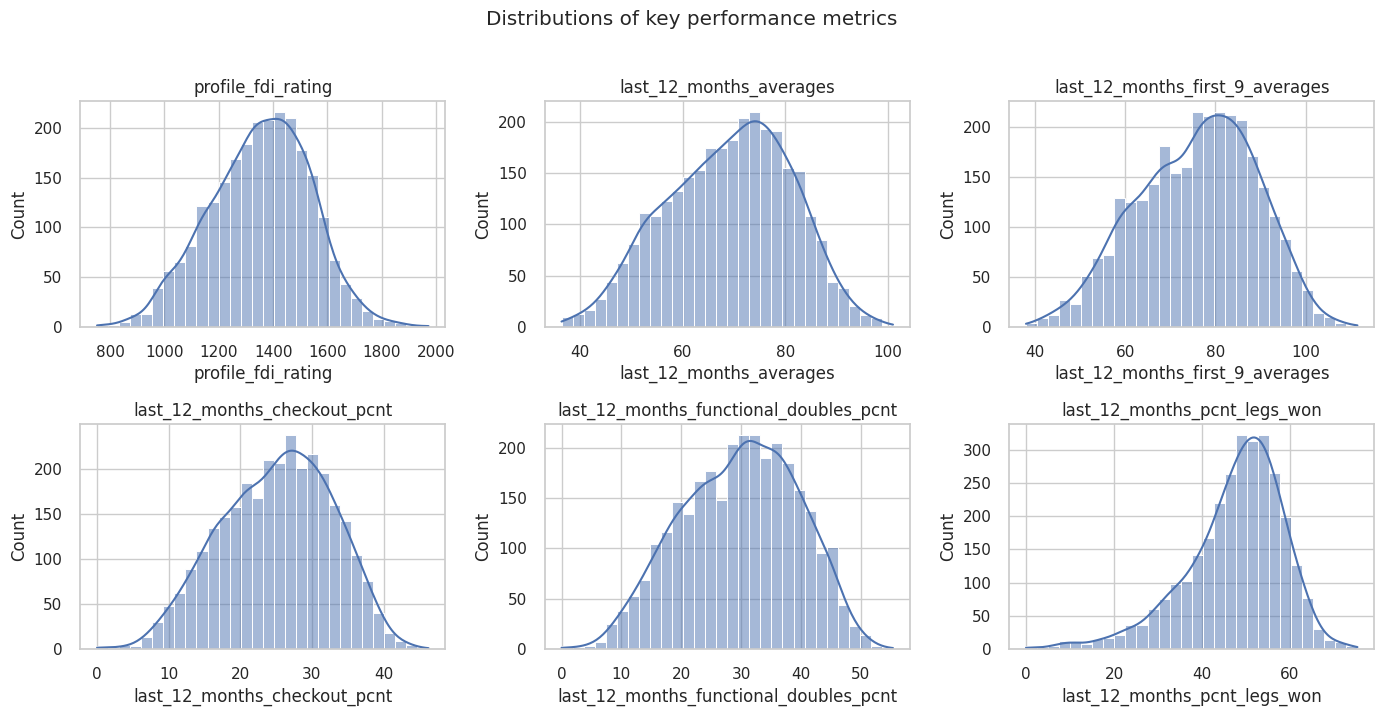

In [23]:
univariate_cols = [
    "profile_fdi_rating",
    "last_12_months_averages",
    "last_12_months_first_9_averages",
    "last_12_months_checkout_pcnt",
    "last_12_months_functional_doubles_pcnt",
    "last_12_months_pcnt_legs_won",
]
fig, axes = plt.subplots(2, 3, figsize=(14, 7))
axes = axes.flatten()
for idx, col in enumerate(univariate_cols):
    sns.histplot(
        df[col].dropna(),
        bins=30,
        kde=True,
        ax=axes[idx],
    )
    axes[idx].set_title(col)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Count")
for ax in axes[len(univariate_cols):]:
    ax.axis("off")
fig.suptitle("Distributions of key performance metrics", y=1.02)
fig.tight_layout()
plt.show()

### Preisgeld (log-transformiert)

Extrem schiefe Geldverteilungen werden im OpenIntro-Ansatz haeufig logarithmiert, um Muster sichtbar zu machen.

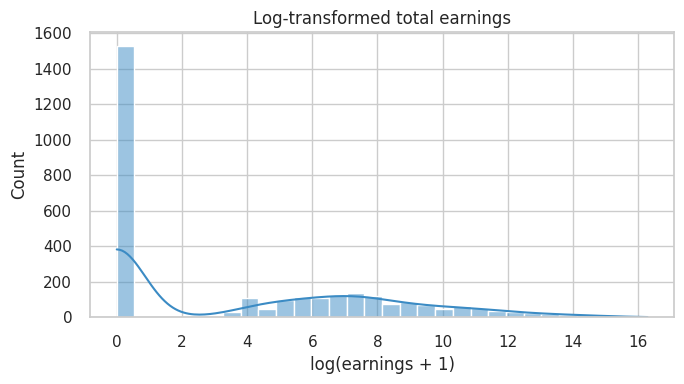

In [24]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.histplot(
    df["log_total_earnings"].replace([np.inf, -np.inf], np.nan).dropna(),
    bins=30,
    kde=True,
    ax=ax,
    color="#3b8bc4",
)
ax.set_title("Log-transformed total earnings")
ax.set_xlabel("log(earnings + 1)")
ax.set_ylabel("Count")
fig.tight_layout()
plt.show()

## Verteilung des FDI-Ratings

Histogramm und Dichtefunktion visualisieren die starke Rechtsschiefe im Longtail der Spielerbasis.

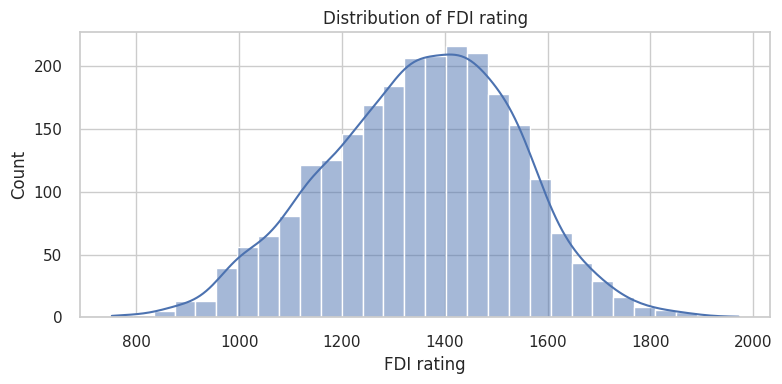

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(
    df["profile_fdi_rating"].dropna(),
    bins=30,
    kde=True,
    ax=ax,
)
ax.set_title("Distribution of FDI rating")
ax.set_xlabel("FDI rating")
ax.set_ylabel("Count")
fig.tight_layout()
plt.show()

## Bivariate Beziehungen zwischen Leistung und Rating

OpenIntro empfiehlt, Zielgroessen direkt gegen moegliche Praediktoren zu vergleichen, um Form (linear/nichtlinear) und Ausreisser zu erkennen.

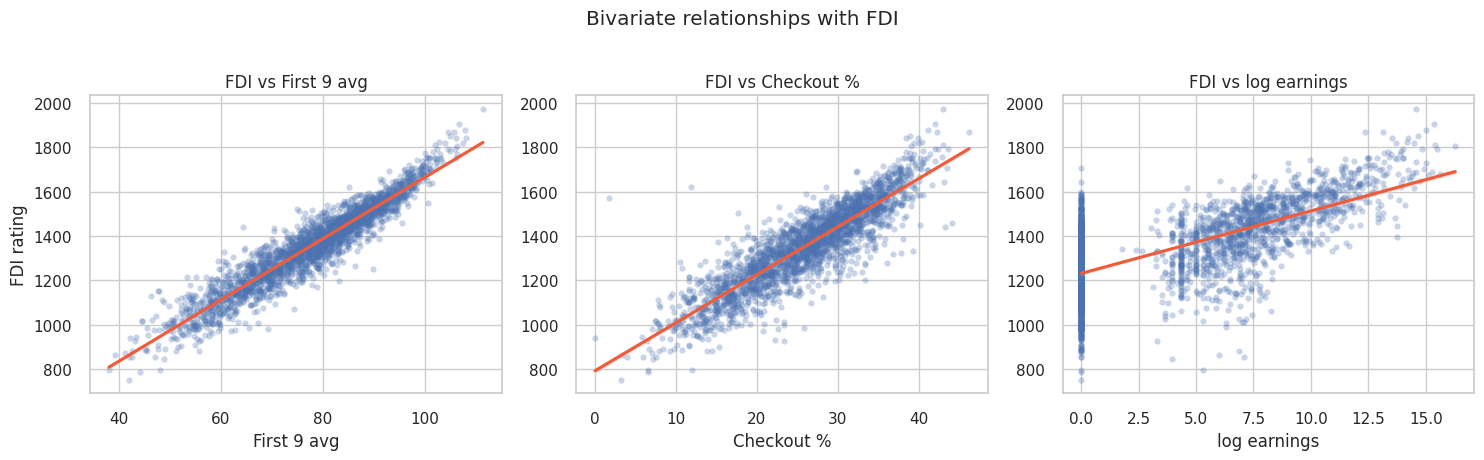

In [26]:
bivariate_pairs = [
    ("last_12_months_first_9_averages", "First 9 avg"),
    ("last_12_months_checkout_pcnt", "Checkout %"),
    ("log_total_earnings", "log earnings"),
]
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
for ax, (feature, label) in zip(axes, bivariate_pairs):
    sns.regplot(
        data=df,
        x=feature,
        y="profile_fdi_rating",
        scatter_kws={"alpha": 0.3, "s": 20},
        line_kws={"color": "#f05c3b"},
        ax=ax,
    )
    ax.set_xlabel(label)
    ax.set_ylabel("FDI rating" if label == "First 9 avg" else "")
    ax.set_title(f"FDI vs {label}")
fig.suptitle("Bivariate relationships with FDI", y=1.02)
fig.tight_layout()
plt.show()

## Top-Spieler nach FDI

Vergleich der absolut staerksten Spieler inklusive Scoring-Intensitaet.

In [27]:
top_cols = [
    "player_name",
    "country_code",
    "profile_fdi_rating",
    "profile_highest_average",
    "last_12_months_first_9_averages",
    "last_12_months_averages"
]
top_players = (
    df.dropna(subset=["profile_fdi_rating"])
    .nlargest(15, "profile_fdi_rating")
    [top_cols]
    .reset_index(drop=True)
)
top_players

,player_name,country_code,profile_fdi_rating,profile_highest_average,last_12_months_first_9_averages,last_12_months_averages
0,Luke Littler,ENG,1972.0,122.96,111.49,100.96
1,Gerwyn Price,WAL,1902.0,117.88,106.73,97.79
2,Luke Humphries,ENG,1876.0,119.15,107.97,98.59
3,Wessel Nijman,NED,1869.0,116.87,104.70,95.91
4,Gian van Veen,NED,1868.0,115.92,105.83,97.92
5,Nathan Aspinall,ENG,1850.0,117.45,104.93,95.72
6,Chris Dobey,ENG,1842.0,113.54,106.13,96.71
7,Josh Rock,NIR,1840.0,121.88,108.11,98.00
8,Danny Noppert,NED,1822.0,110.68,102.78,94.81
9,Stephen Bunting,ENG,1819.0,117.12,107.59,98.04


## Korrelation zentraler Kennzahlen

Heatmap hebt die Beziehungen zwischen Scoring-, Checkout- und Momentum-KPIs hervor.

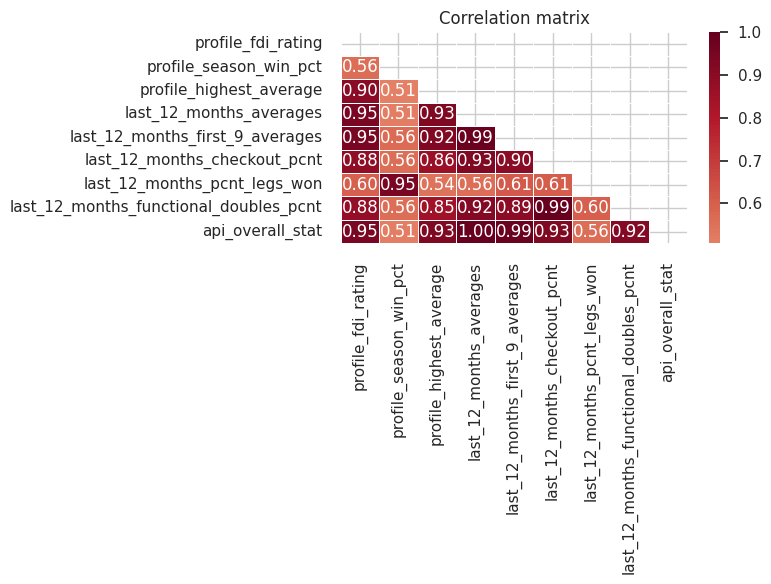

In [28]:
corr_features = [
    "profile_fdi_rating",
    "profile_season_win_pct",
    "profile_highest_average",
    "last_12_months_averages",
    "last_12_months_first_9_averages",
    "last_12_months_checkout_pcnt",
    "last_12_months_pcnt_legs_won",
    "last_12_months_functional_doubles_pcnt",
    "api_overall_stat"
]
corr_matrix = df[corr_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5,
    ax=ax,
)
ax.set_title("Correlation matrix")
fig.tight_layout()
plt.show()

## Lander-Vergleich

Durchschnittliches Rating je Nation (nur Laender mit mindestens 10 gelisteten Spielerinnen/Spielern).

In [29]:
country_summary = (
    df.dropna(subset=["profile_fdi_rating"])
    .groupby("country_code")
    .agg(
        players=("player_id", "count"),
        avg_fdi=("profile_fdi_rating", "mean"),
        median_fdi=("profile_fdi_rating", "median"),
    )
    .query("players >= 10")
    .sort_values("avg_fdi", ascending=False)
    .head(10)
)
country_summary

,players,avg_fdi,median_fdi
country_code,,,
SCO,49,1485.714286,1500.0
POL,17,1482.764706,1488.0
SWE,20,1458.850000,1474.5
NIR,21,1453.714286,1425.0
PHI,33,1451.545455,1448.0
IRL,48,1406.166667,1408.5
AUT,19,1400.157895,1411.0
WAL,73,1396.931507,1431.0
GER,206,1395.800971,1408.5


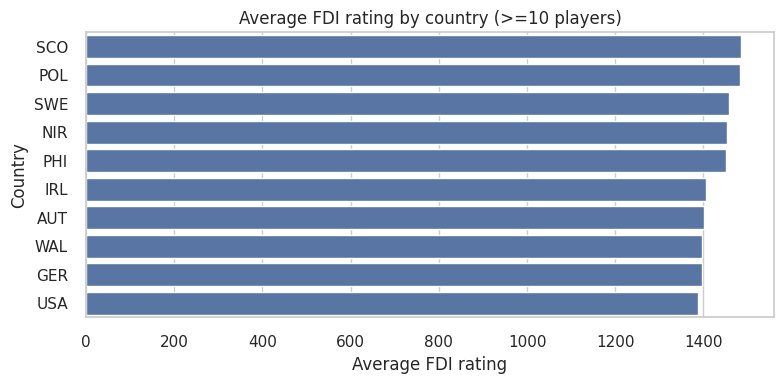

In [30]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(
    data=country_summary.reset_index(),
    x="avg_fdi",
    y="country_code",
    ax=ax,
)
ax.set_title("Average FDI rating by country (>=10 players)")
ax.set_xlabel("Average FDI rating")
ax.set_ylabel("Country")
fig.tight_layout()
plt.show()

### Verteilung nach Top-Laendern

Neben Lageparametern betrachtet OpenIntro die gesamte Verteilungsform innerhalb kategorialer Gruppen.

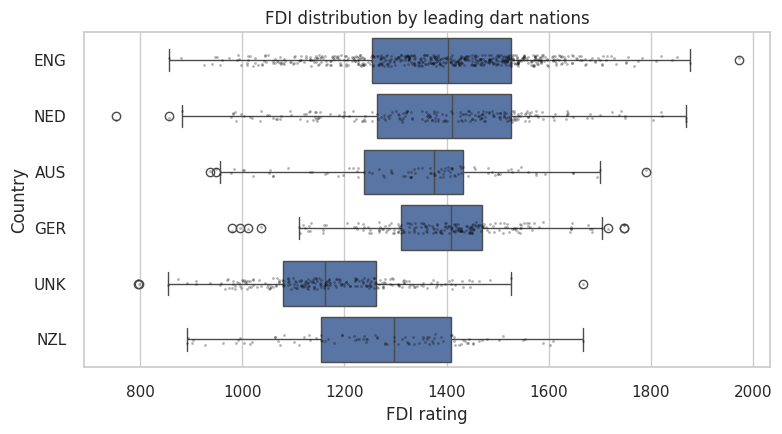

In [31]:
top_country_list = df["country"].value_counts().nlargest(6).index
country_filtered = df[df["country"].isin(top_country_list)]
fig, ax = plt.subplots(figsize=(8, 4.5))
sns.boxplot(
    data=country_filtered,
    x="profile_fdi_rating",
    y="country",
    ax=ax,
    whis=1.5,
)
sns.stripplot(
    data=country_filtered,
    x="profile_fdi_rating",
    y="country",
    ax=ax,
    color="black",
    alpha=0.3,
    size=2,
)
ax.set_title("FDI distribution by leading dart nations")
ax.set_xlabel("FDI rating")
ax.set_ylabel("Country")
fig.tight_layout()
plt.show()

## Multivariate Muster & Ausreisser

Scatterplot-Matrizen und Z-Score-Checks helfen laut OpenIntro, kombinierte Trends sowie extreme Beobachtungen zu isolieren.

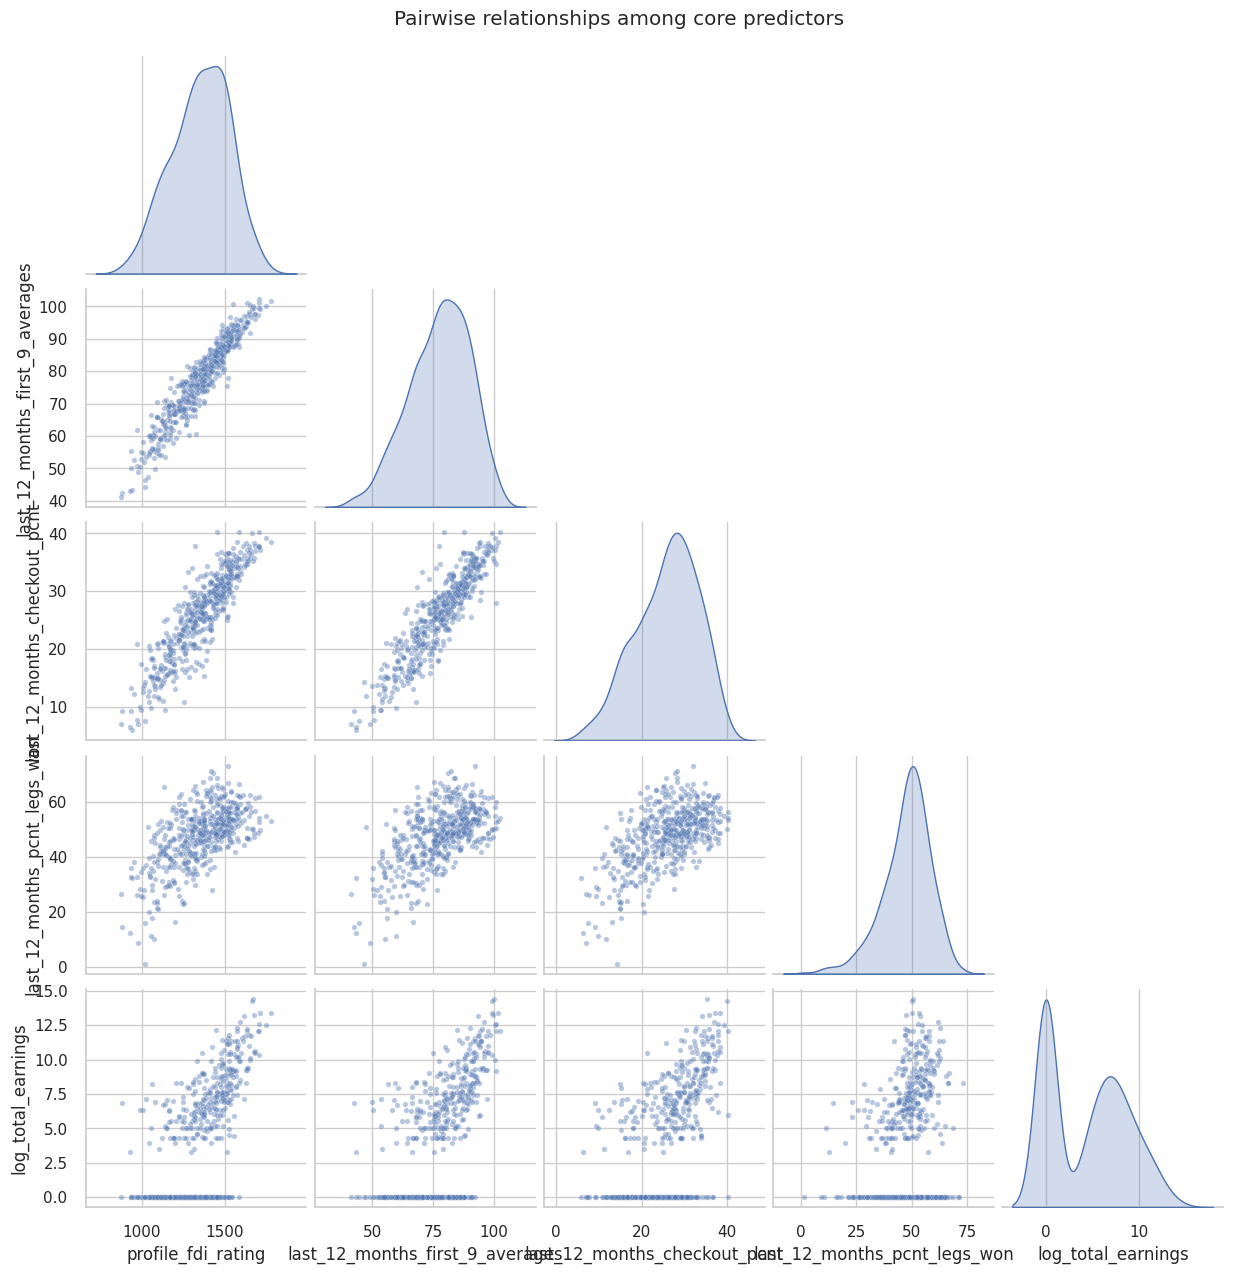

In [32]:
pairplot_cols = [
    "profile_fdi_rating",
    "last_12_months_first_9_averages",
    "last_12_months_checkout_pcnt",
    "last_12_months_pcnt_legs_won",
    "log_total_earnings",
]
pairplot_df = df[pairplot_cols].dropna()
sample_size = min(500, len(pairplot_df))
pairplot_sample = pairplot_df.sample(n=sample_size, random_state=42)
sns.pairplot(
    pairplot_sample,
    corner=True,
    diag_kind="kde",
    plot_kws={"alpha": 0.4, "s": 15},
)
plt.suptitle("Pairwise relationships among core predictors", y=1.02)
plt.show()

In [33]:
rating_z = (df["profile_fdi_rating"] - df["profile_fdi_rating"].mean()) / df["profile_fdi_rating"].std()
outliers = (
    df.assign(rating_z=rating_z)
    .loc[rating_z.abs() > 3, [
        "player_name",
        "country",
        "profile_fdi_rating",
        "last_12_months_first_9_averages",
        "last_12_months_checkout_pcnt",
        "log_total_earnings",
        "rating_z",
    ]]
    .sort_values("profile_fdi_rating", ascending=False)
)
outliers

,player_name,country,profile_fdi_rating,last_12_months_first_9_averages,last_12_months_checkout_pcnt,log_total_earnings,rating_z
0,Luke Littler,ENG,1972.0,111.49,42.97,14.577195,3.375773
2975,Ivy Bradford-Shaw,UNK,797.0,38.01,6.59,0.000000,-3.030525
2911,Tracey Reeve,UNK,796.0,48.00,11.94,5.303305,-3.035977
2965,Emmanuel Musambayi,KEN,786.0,44.09,6.59,0.000000,-3.090499
2973,Annemarie van Kaathoven,NED,752.0,41.95,3.17,0.000000,-3.275873


## Kernerkenntnisse & Implikationen

- FDI-Rating folgt einer rechtsschiefen Verteilung; log-transformierte Earnings sind nuetzlich, um den Longtail der Semi-Pros sichtbar zu machen.
- Bivariate Analysen zeigen fast-lineare Zusammenhaenge zwischen Scoring-Statistiken (First-9, Checkout) und dem Rating; Preisgeld wirkt nur nach Log-Transformation halbwegs linear.
- Top-Laender unterscheiden sich vor allem in der Streuung: ENG/NED breites Spektrum, DACH enger - wichtig fuer spaetere Dummy-Kodierung.
- Die Pairplot-Analyse bestaetigt starke Korrelationen zwischen Momentum- und Checkout-KPIs; Ausreisser-Z-Score identifiziert nur eine Handvoll Extremfaelle, die separat validiert werden sollten.